In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Năm 3/HPC/HPC - Nhóm 8/HPC - Đồ án"

/content/drive/MyDrive/Năm 3/HPC/HPC - Nhóm 8/HPC - Đồ án


In [ ]:
!pwd

/content/drive/MyDrive/Năm 3/HPC/HPC - Nhóm 8/HPC - Đồ án


# **Libraries**

In [ ]:
!pip install holidays
!pip install torchinfo

In [ ]:
import os
import time
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from xgboost import XGBRegressor
import holidays

# **Data Exploration**

In [ ]:
df = pd.read_csv("./data/raw/ankhanh_measurements.csv")

In [ ]:
# Đổi tên cột: loại bỏ đơn vị
df.rename(columns={
    "co µg/m³": "co",
    "pm25 µg/m³": "pm25",
    "no2 µg/m³": "no2",
    "pm10 µg/m³": "pm10"
}, inplace=True)

# Xóa các cột: 'datetimeTo_utc', 'datetimeTo_local', 'datetimeFrom_utc'
df.drop(columns=['datetimeTo_utc', 'datetimeTo_local', 'datetimeFrom_utc'], inplace=True)

# Chuyển đổi kiểu dữ liệu của các cột kiểu datetime
df['datetimeFrom_local'] = pd.to_datetime(df['datetimeFrom_local'])

Dùng giờ local trong time series phân tích môi trường vì hoạt động con người, giao thông, khí thải... diễn ra theo giờ địa phương
→ Ô nhiễm không khí thường tăng vào giờ cao điểm sáng/tối, ngày thường vs cuối tuần.

In [ ]:
df.head()

,datetimeFrom_local,co,pm25,no2,pm10
0,2024-01-29 13:00:00+07:00,631.0,43.4,8.7,59.4
1,2024-01-29 14:00:00+07:00,642.0,42.9,11.2,56.5
2,2024-01-30 04:00:00+07:00,934.0,82.8,15.7,90.9
3,2024-01-30 05:00:00+07:00,1010.0,76.4,15.5,84.0
4,2024-01-30 06:00:00+07:00,868.0,70.4,14.4,77.4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8881 entries, 0 to 8880
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype                    
---  ------              --------------  -----                    
 0   datetimeFrom_local  8881 non-null   datetime64[ns, UTC+07:00]
 1   co                  8873 non-null   float64                  
 2   pm25                8866 non-null   float64                  
 3   no2                 8874 non-null   float64                  
 4   pm10                8847 non-null   float64                  
dtypes: datetime64[ns, UTC+07:00](1), float64(4)
memory usage: 347.0 KB


Feature Engineering

Fill thời gian bị ngắt quãng bằng NaN

In [ ]:
df = df.set_index('datetimeFrom_local')

# Tạo lại dãy thời gian liên tục
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='1h')

# Reindex để thêm dòng thiếu
df = df.reindex(full_index)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11402 entries, 2024-01-29 13:00:00+07:00 to 2025-05-18 14:00:00+07:00
Freq: h
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co      8873 non-null   float64
 1   pm25    8866 non-null   float64
 2   no2     8874 non-null   float64
 3   pm10    8847 non-null   float64
dtypes: float64(4)
memory usage: 445.4 KB


Có tổng cộng 11402 bản ghi

Kiểm tra tính dừng (stationarity) của 4 features

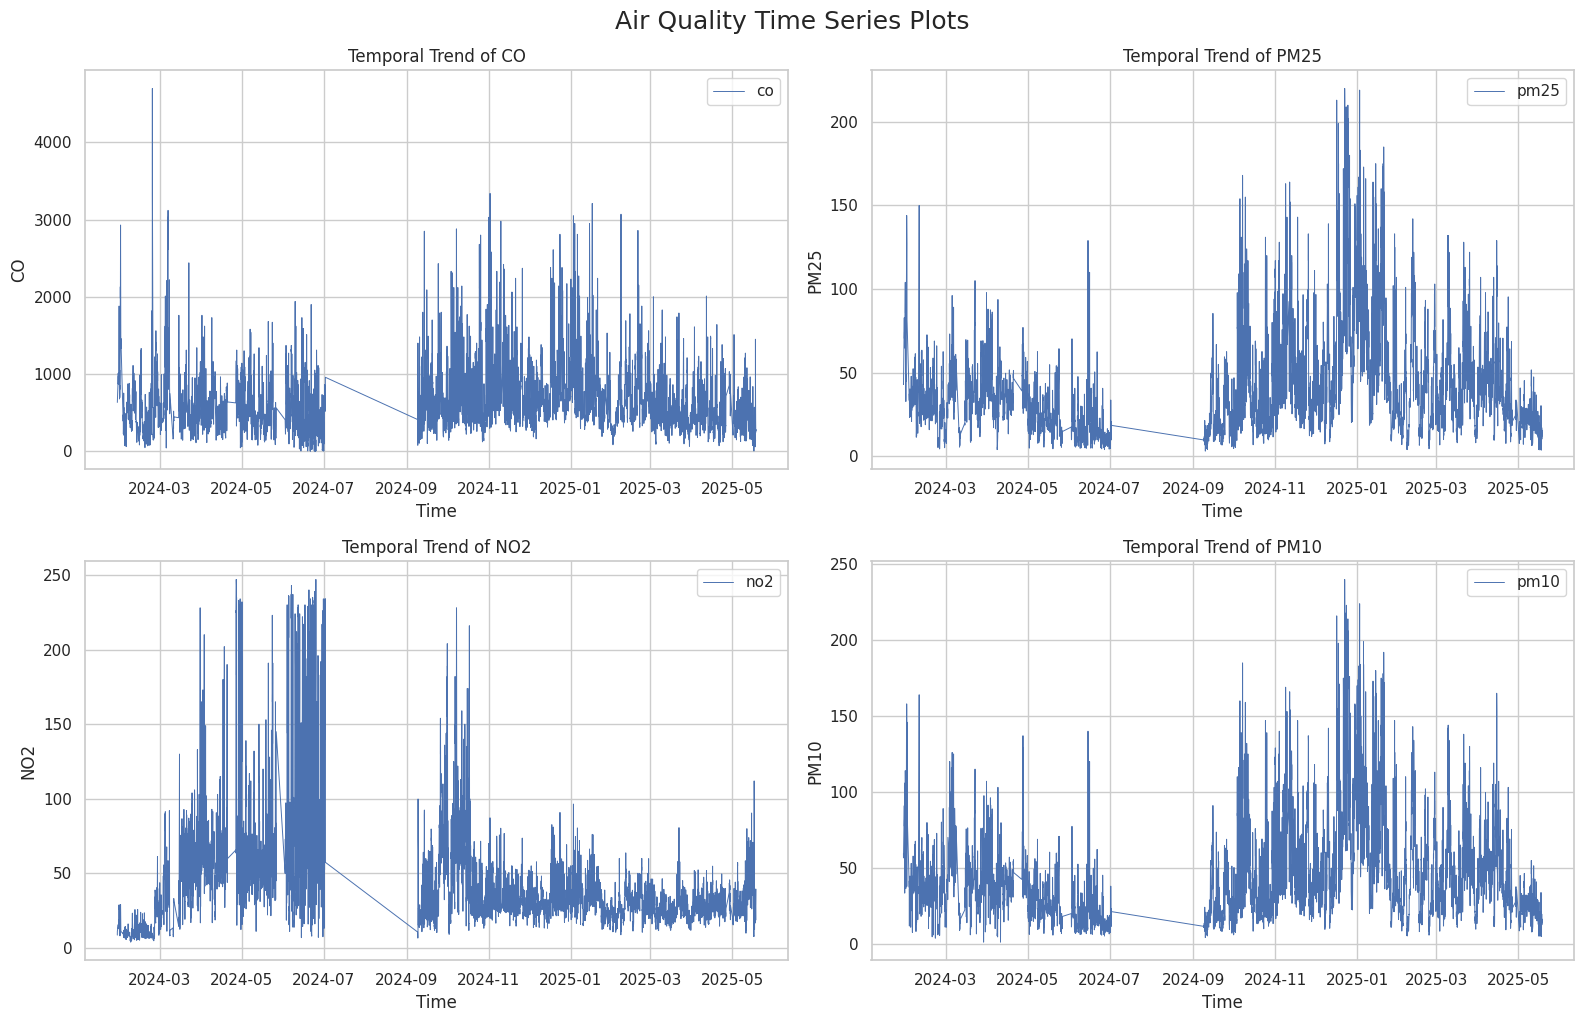

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))

# Danh sách các cột cần vẽ
features = ['co', 'pm25', 'no2', 'pm10']

for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.lineplot(data=df[feature], label=feature, linewidth=0.7)
    plt.title(f'Temporal Trend of {feature.upper()}')
    plt.xlabel('Time')
    plt.ylabel(f'{feature.upper()}')
    plt.tight_layout()

plt.suptitle('Air Quality Time Series Plots', fontsize=18, y=1.02)
plt.show()

Quãng thời gian từ tháng 7/2024 đến tháng 9/2024 bị thiếu dữ liệu ở cả 4 cột

In [ ]:
df.isnull().sum() / df.shape[0] * 100

,0
co,22.180319
pm25,22.241712
no2,22.171549
pm10,22.408349


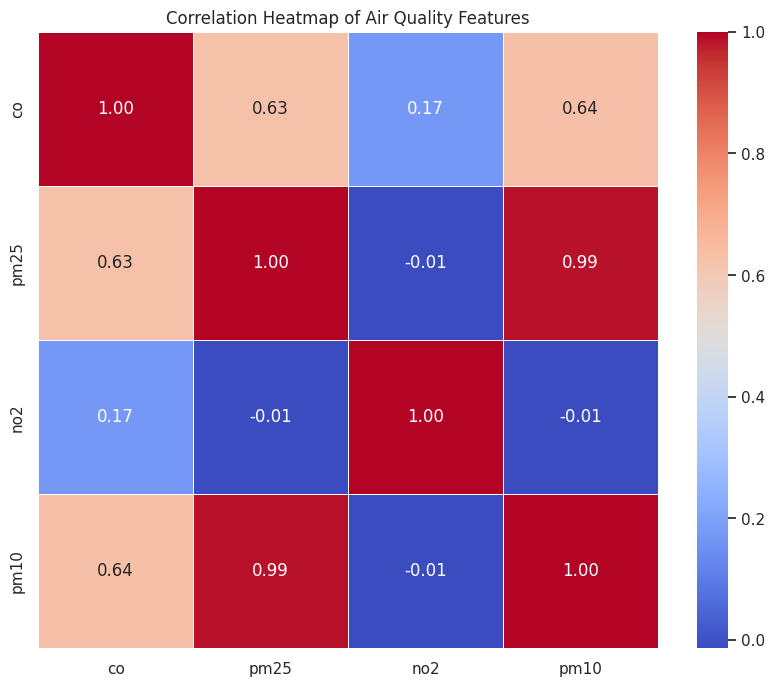

In [ ]:

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Air Quality Features')
plt.show()

Bỏ feature pm10

In [ ]:
df.drop(columns=['pm10'], inplace=True)

In [ ]:
extended_describe = df.describe().T
extended_describe['median'] = df.median()
extended_describe['skewness'] = df.skew()
extended_describe['kurtosis'] = df.kurtosis()
extended_describe

,count,mean,std,min,25%,50%,75%,max,median,skewness,kurtosis
co,8873.0,630.703595,412.881635,0.0,367.0,531.00,781.0,4700.0,531.00,2.087652,7.314189
pm25,8866.0,40.667573,29.699371,3.0,20.0,33.20,51.5,220.0,33.20,1.787903,4.293908
no2,8874.0,44.198118,36.647578,4.0,23.4,32.85,53.7,247.0,32.85,2.711888,8.998970


Khoảng giá trị của các chỉ số đo lường khác nhau, cần chuẩn hóa

Nhận xét về tính dừng:
- CO: Không dừng – có xu hướng và biến động mạnh theo thời gian.

- PM2.5: Không dừng – có xu hướng, mùa vụ và dao động lớn.

- NO2: Không dừng – thay đổi rõ rệt về mức độ và phương sai giữa các giai đoạn.

- PM10: Không dừng – có xu hướng, mùa vụ và biến động không ổn định.

=> Tất cả các chuỗi đều không dừng, cần xử lý trước khi dự báo (như sai phân, log, v.v.).

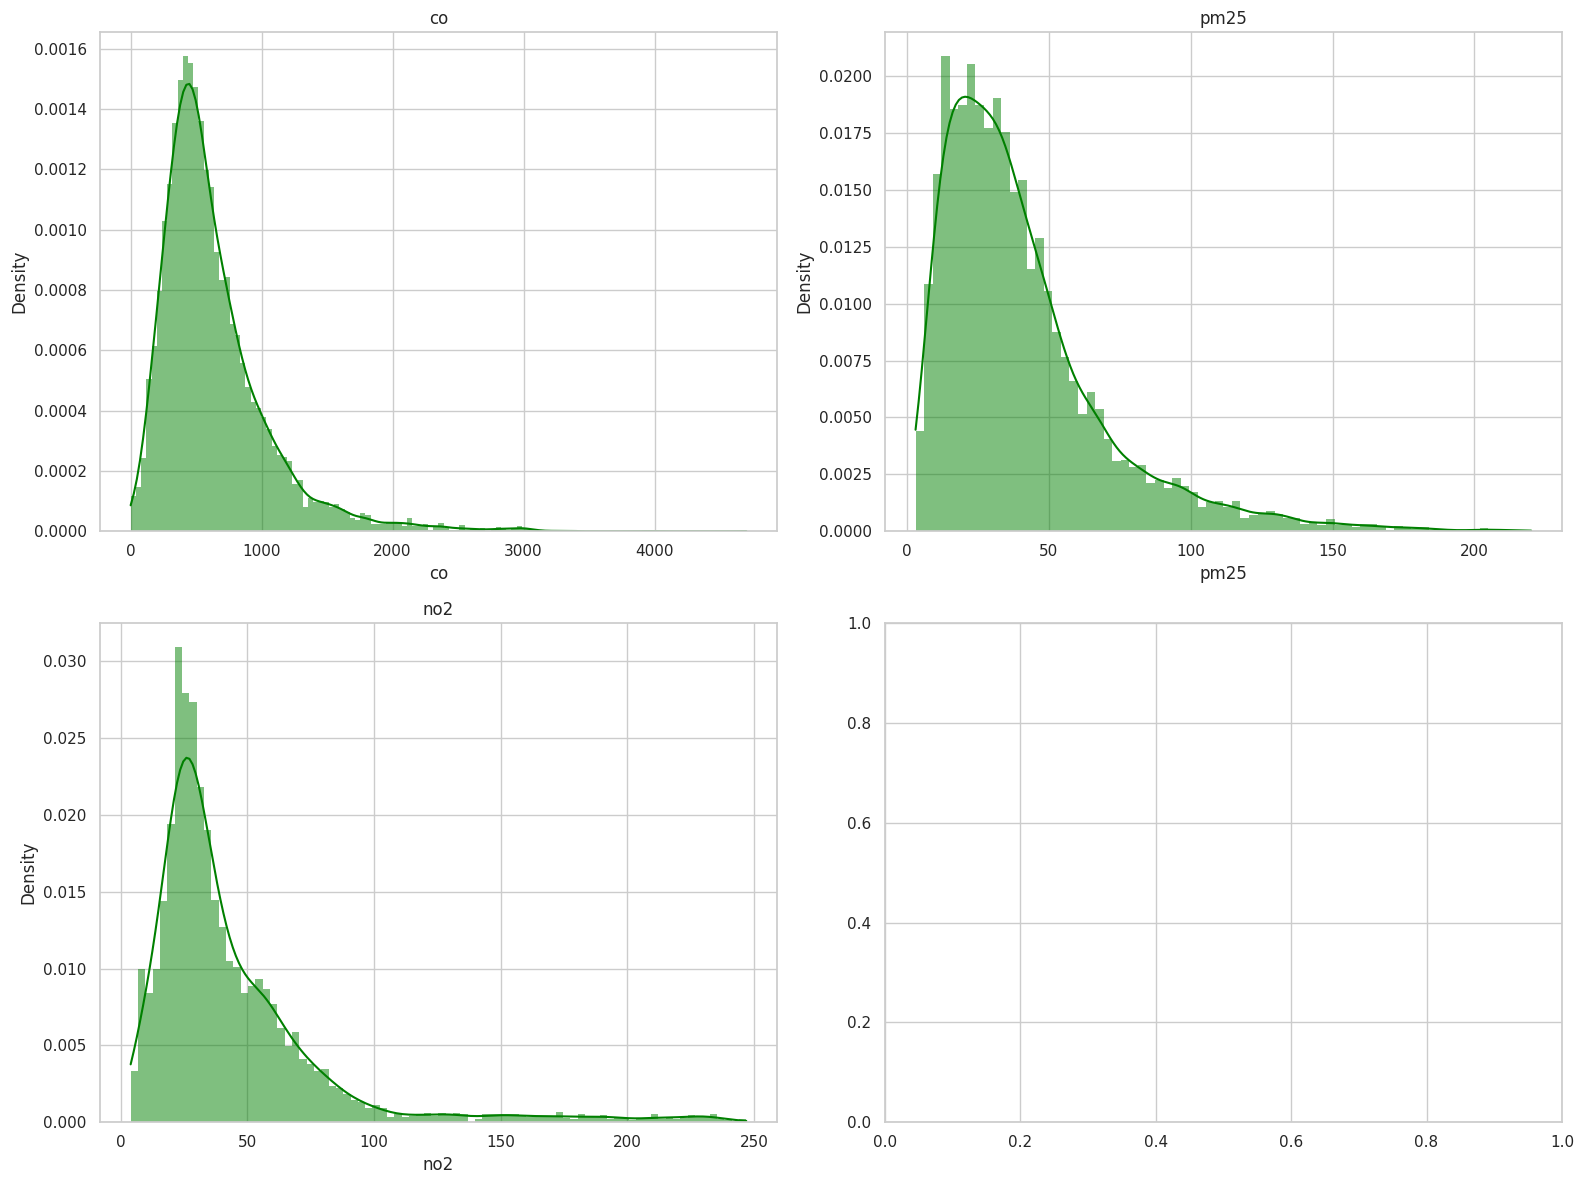

In [ ]:
# Kiểm tra phân phối
columns_to_plot = ["co", "pm25", "no2"]

num_columns = 2
num_rows = int(np.ceil(len(columns_to_plot) / num_columns))
grid_layout = (num_rows, num_columns)
fig, axes = plt.subplots(*grid_layout, figsize=(16, 12))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.histplot(df[column], kde=True, ax=axes[i],
             color="green", stat="density", linewidth=0)
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

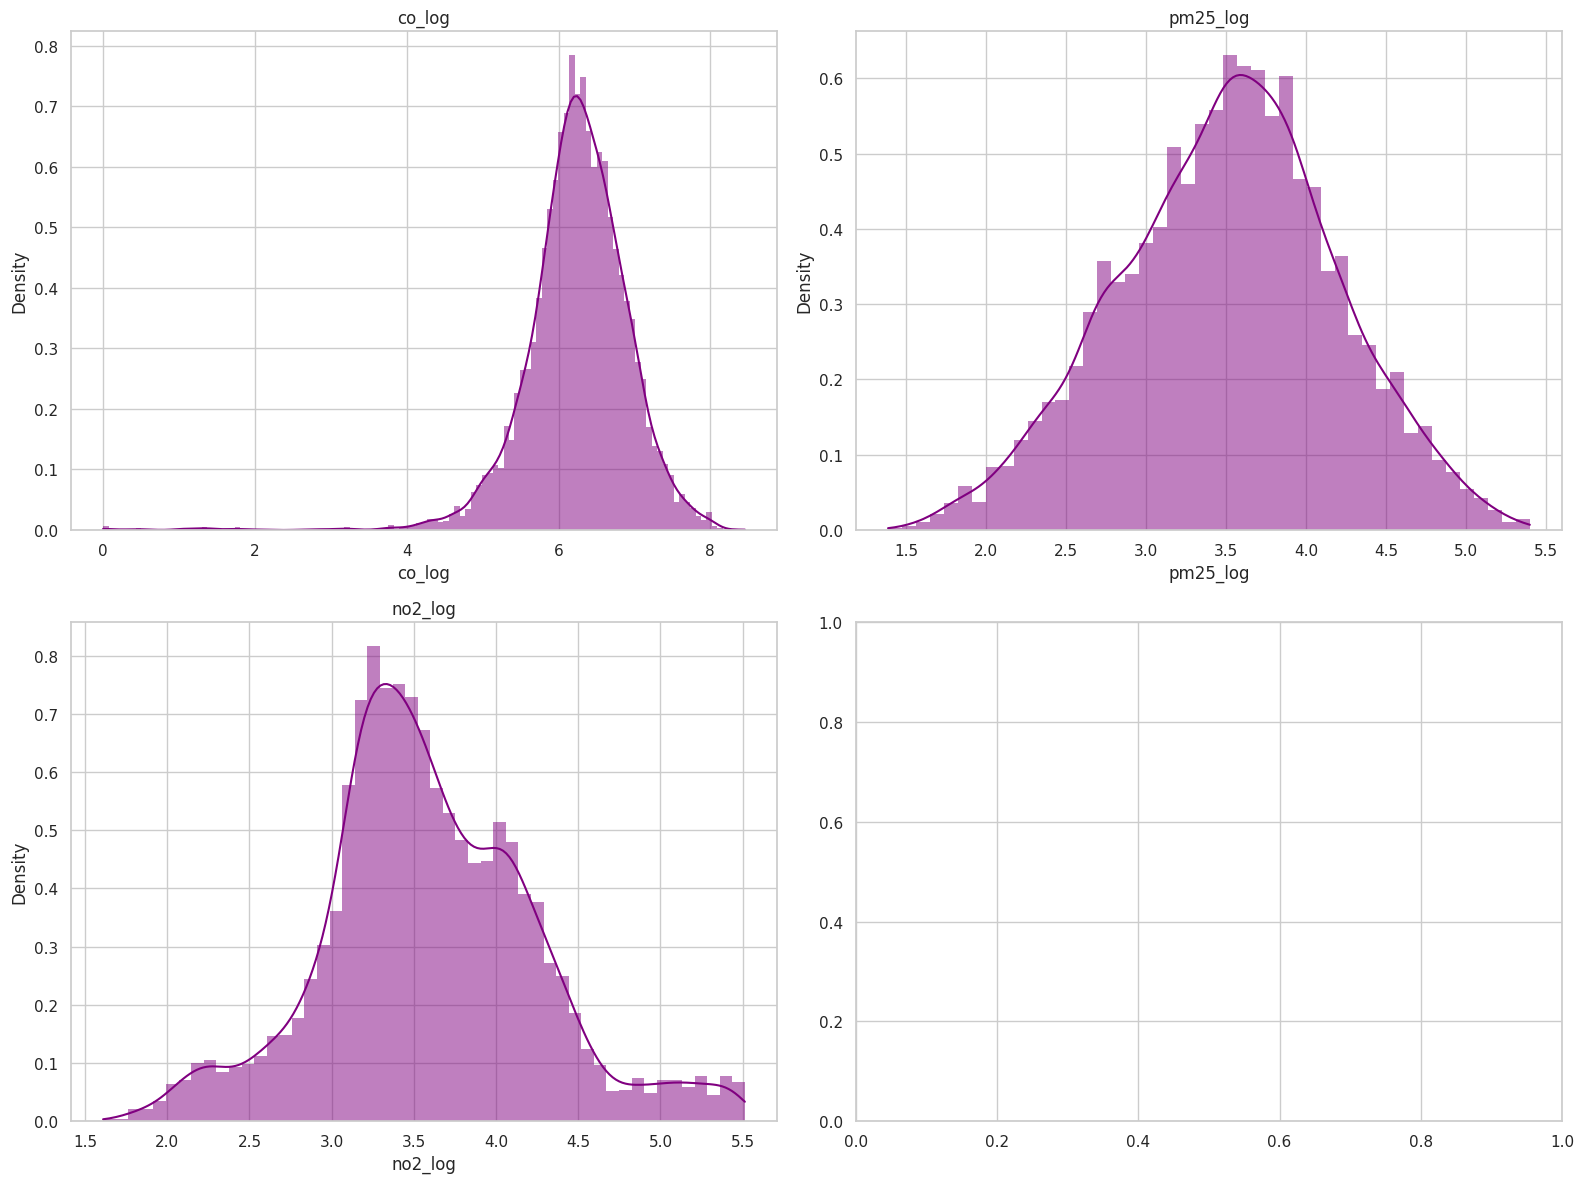

Descriptive statistics after Log Transform:
           count      mean       std       min       25%       50%       75%  \
co_log    8873.0  6.251077  0.689267  0.000000  5.908083  6.276643  6.661855   
pm25_log  8866.0  3.503809  0.683655  1.386294  3.044522  3.532226  3.960813   
no2_log   8874.0  3.585125  0.650071  1.609438  3.194583  3.521938  4.001864   

               max  
co_log    8.455531  
pm25_log  5.398163  
no2_log   5.513429  


In [ ]:
# Áp dụng log transform cho các cột có phân phối lệch phải
# Chỉ áp dụng cho giá trị > 0 để tránh log(0)
for col in columns_to_plot:
    df[f'{col}_log'] = np.log1p(df[col]) # Sử dụng log1p để xử lý giá trị 0 nếu có

# Kiểm tra phân phối sau log transform
columns_to_plot_log = [f"{col}_log" for col in columns_to_plot]

num_columns = 2
num_rows = int(np.ceil(len(columns_to_plot_log) / num_columns))
grid_layout = (num_rows, num_columns)
fig, axes = plt.subplots(*grid_layout, figsize=(16, 12))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot_log):
    sns.histplot(df[column], kde=True, ax=axes[i],
             color="purple", stat="density", linewidth=0)
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

# Hiển thị mô tả thống kê cho các cột đã log transform
print("Descriptive statistics after Log Transform:")
print(df[columns_to_plot_log].describe().T)
